In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

# --- helpers ---
def eit_envelope(eit_2d: np.ndarray) -> np.ndarray:
    """RMS across channels -> 1D envelope."""
    return np.sqrt((eit_2d.astype(np.float64) ** 2).mean(axis=1))

def shared_minmax(a: np.ndarray, b: np.ndarray, qlo=0, qhi=100):
    """Shared min–max (optionally robust via percentiles)."""
    combo = np.concatenate([a, b])
    lo = np.nanpercentile(combo, qlo); hi = np.nanpercentile(combo, qhi)
    rng = max(hi - lo, 1e-8)
    return np.clip((a - lo)/rng, 0, 1), np.clip((b - lo)/rng, 0, 1)

def x_axis(T: int, fs: Optional[float]):
    return (np.arange(T, dtype=np.float64) / fs) if fs else np.arange(T, dtype=np.float64)

# --- 3 requested plots ---
def make_three_plots(eit: np.ndarray, pap_on_eit: np.ndarray, eit_sr: Optional[float] = None):
    assert eit.shape[0] == len(pap_on_eit), "EIT and PAP must have same length"
    T = len(pap_on_eit)
    x = x_axis(T, eit_sr)
    xlabel = "Time (s)" if eit_sr else "Sample"

    # 1) Overlay normalized 0–1
    env = eit_envelope(eit)
    env_n, pap_n = shared_minmax(env, pap_on_eit, qlo=5, qhi=95)  # robust to outliers
    plt.figure()
    plt.title("Overlay (normalized 0–1, shared scale)")
    plt.plot(x, env_n, label="EIT envelope (norm.)", linewidth=0.9)
    plt.plot(x, pap_n, label="PAP (norm.)", linewidth=0.9)
    plt.xlabel(xlabel); plt.ylabel("Normalized amplitude")
    plt.legend(); plt.tight_layout()

    # 2) Raw overlay with twin y-axes
    fig, ax1 = plt.subplots()
    fig.suptitle("Raw overlay (twin axes)")
    l1 = ax1.plot(x, env, color="C0", linewidth=0.9, label="EIT envelope (a.u.)")
    ax1.set_xlabel(xlabel); ax1.set_ylabel("EIT envelope (a.u.)", color="C0")
    ax1.tick_params(axis='y', labelcolor="C0")
    ax2 = ax1.twinx()
    l2 = ax2.plot(x, pap_on_eit, color="C1", linewidth=0.9, label="PAP (mmHg)")
    ax2.set_ylabel("PAP (mmHg)", color="C1")
    ax2.tick_params(axis='y', labelcolor="C1")
    # one combined legend
    lines = l1 + l2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right")
    fig.tight_layout()

    # 3) Stacked raw traces (separate axes)
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
    fig.suptitle("Raw signals (stacked)")
    ax_top.plot(x, env, linewidth=0.9)
    ax_top.set_ylabel("EIT env (a.u.)")
    ax_bot.plot(x, pap_on_eit, linewidth=0.9)
    ax_bot.set_ylabel("PAP (mmHg)")
    ax_bot.set_xlabel(xlabel)
    fig.tight_layout()



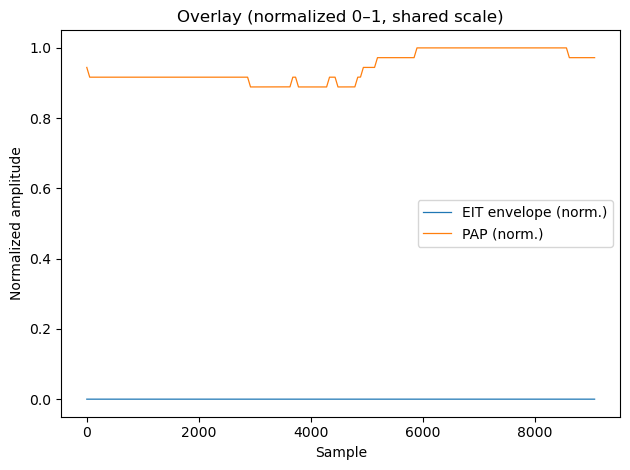

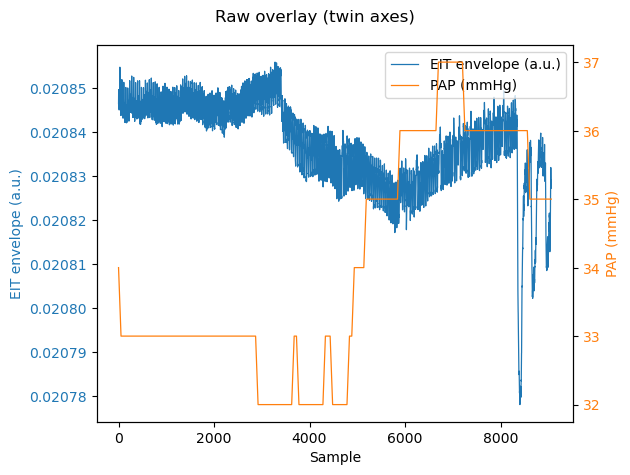

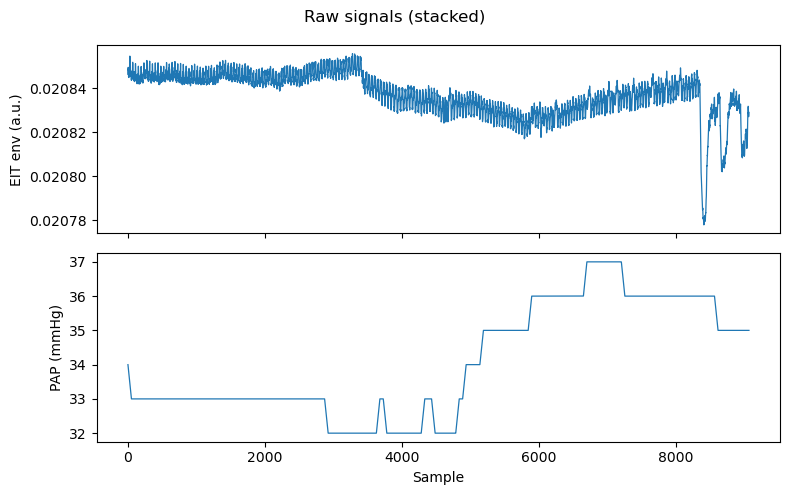

In [9]:
# ---------- Config ----------
FOLDER_BASE = r"data_displaid_tidal\data_tilda_transformed"
patient_id = "TDL012"   # <- change this

# Build paths
eit_csv = fr"{FOLDER_BASE}\Data Raw Voltage apnea\{patient_id}_voltage_apnea.csv"
pap_csv = fr"{FOLDER_BASE}\Data pap apnea upscaled\{patient_id}_pap_on_voltage_apnea.csv"


eit = pd.read_csv(eit_csv, header=None).values.astype(np.float32)                     # (T, C)
pap_on_eit = pd.read_csv(pap_csv)["PAP_on_VoltageApnea (mmHg)"].values.astype(np.float32)      # (T,)
assert eit.shape[0] == len(pap_on_eit)

EIT_SR = None  # set to 50.355 if you want seconds on x-axis
make_three_plots(eit, pap_on_eit, eit_sr=EIT_SR)
plt.show()
